
<img src="https://raw.githubusercontent.com/akscent/kaggle-competitions/main/Alfa%20MIPT/img/banner.PNG">

# Описание задачи
Одной из задач в любом банке является эффективное распределение наличных денежных средств, в том числе и в банкоматах. Оптимальная загрузка АТМ позволяет экономить на фондировании, в противном случае банк теряет деньги из-за простоя лишних денежных купюр.

Но для того, чтобы знать, сколько денег нужно держать в банкомате, нужно уметь прогнозировать спрос на выдачу на несколько дней вперёд.

В этом конкурсе предлагается научиться предсказывать выдачу денег в АТМ в горизонте 14 дней.

**Полезная информация**

Для конкурса предоставлены данные по ресайклинговым АТМ. Основное отличие таких АТМ от остальных заключается в отсутствии разбиения кассет на приём и выдачу наличных: куппюра, которая попала в АТМ может быть выдана при следующей операции.
Так же все АТМ расположены в свободном доступе (ТЦ, магазины, отделения) в городах миллионниках, не являясь зарплатными.

[BaseLine](https://www.kaggle.com/code/evgeniigavrilin/baseline)

# Импорт интрументов

In [ ]:
%%catch
import warnings
warnings.filterwarnings('ignore')
%pip install --upgrade pip
%pip install holidays soundfile hydra-slayer botocore==1.27.59 etna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
import itertools
import seaborn as sns
from datetime import datetime, timedelta

from etna.datasets import generate_ar_df
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.analysis import (plot_backtest, plot_anomalies, plot_forecast, metric_per_segment_distribution_plot, 
                           plot_residuals, plot_metric_per_segment, prediction_actual_scatter_plot)
from etna.datasets.utils import duplicate_data
from etna.analysis.outliers import get_anomalies_density
from etna.pipeline import Pipeline
from etna.models import CatBoostModelMultiSegment, CatBoostModelPerSegment
from etna.transforms import (TimeSeriesImputerTransform, LagTransform, MeanTransform, MinMaxDifferenceTransform, TreeFeatureSelectionTransform, DateFlagsTransform,
                             DateFlagsTransform, DensityOutliersTransform, STLTransform, StandardScalerTransform,
                             MinTransform, MaxTransform, MADTransform, HolidayTransform, FourierTransform)

from typing import Optional, Sequence

from tqdm.notebook import tqdm

# Подготовка данных и функций

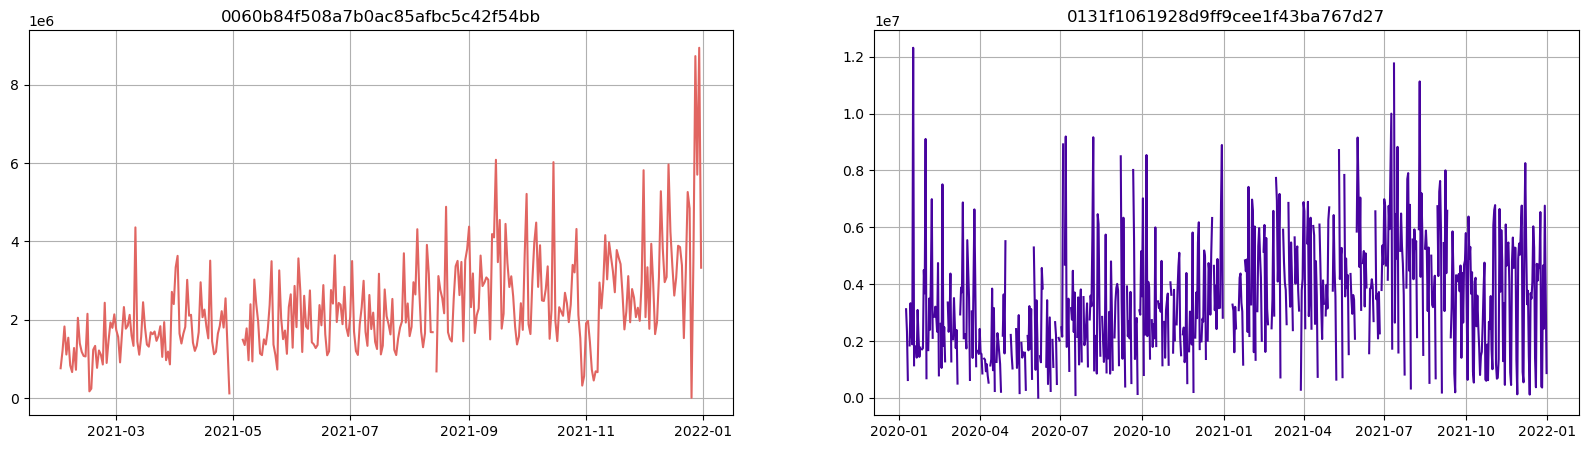

In [4]:
def preprocess_dataframe(df):
    original_df = df.copy()
    original_df["timestamp"] = pd.to_datetime(original_df["value_day"])
    original_df["segment"] = original_df["atm_id"]
    original_df.drop(columns=["value_day", "atm_id"], inplace=True)
    return TSDataset.to_dataset(original_df)

HORIZON = 14

df_train = pd.read_csv("/kaggle/input/alfamipt-2023-atm-cash-prediction/train.csv")
df_test = pd.read_csv("/kaggle/input/alfamipt-2023-atm-cash-prediction/test.csv")
df_concat = pd.concat([df_train, df_test], axis=0, ignore_index=True)

overall_df = preprocess_dataframe(df_concat)

# для визуализации рядов немного кастомизировал родительский класс
class CustomTSDataset(TSDataset):
    """
        Захотелось добавить разные цвета графикам
    """
    def plot_custom_color(
            self,
            n_segments: int = 10,
            column: str = "target",
            segments: Optional[Sequence[str]] = None,
            start: Optional[str] = None,
            end: Optional[str] = None,
            seed: int = 1,
            figsize: tuple = (10, 5),
            colors: Optional[Sequence[str]] = None
    ):
        if segments is None:
            segments = self.segments
            k = min(n_segments, len(segments))
        else:
            k = len(segments)
        columns_num = min(2, k)
        rows_num = math.ceil(k / columns_num)
        start = self.df.index.min() if start is None else pd.Timestamp(start)
        end = self.df.index.max() if end is None else pd.Timestamp(end)
        figsize = (figsize[0] * columns_num, figsize[1] * rows_num)
        _, ax = plt.subplots(rows_num, columns_num, figsize=figsize, squeeze=False)
        ax = ax.ravel()
        rnd_state = np.random.RandomState(seed)
        for i, segment in enumerate(sorted(rnd_state.choice(segments, size=k, replace=False))):
            df_slice = self[start:end, segment, column]  # type: ignore
            if colors is None:
                color = 'blue'
            else:
                color = colors[i]
            ax[i].plot(df_slice.index, df_slice.values, color=color)
            ax[i].set_title(segment)
            ax[i].grid()

ts_train_graph = CustomTSDataset(overall_df, freq="1D")
ts_train_graph.plot_custom_color(segments=ts_train_graph.segments[:2], colors=['#E16561', '#47039F'])

In [5]:
# тренировочная выборка (включая тестовый набор)
ts_overall = TSDataset(overall_df, freq="D")

# тестовый набор данных
test_df = preprocess_dataframe(df_test)
ts_test = TSDataset(test_df, freq="D")

> Задача - проверить корреляции между банкоматами из тренировочного датасета и тестового набора при условии, что тренировочные временные ряды должны заканчиваться позже, чем соответствующий тестовый временной ряд.

In [6]:
# Корреляции временных рядов
def get_redundant_pairs(df):
    '''Без дублирования'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, max, min):
    '''Получим топ коррелируемых переменных'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    filtercorr = au_corr[((au_corr >= max) & (au_corr <= min)) | ((au_corr <= - max ) & (au_corr >= - min)) & (au_corr !=1.000)]
    filtercorr = filtercorr.to_frame().reset_index()
    filtercorr.columns = ['atm_id_1', 'atm_id_2', 'correlation']
    return filtercorr

def plot_top_abs_correlations(df, max, min):
    '''Визуализируем топ коррелируемых переменных'''
    filtercorr = get_top_abs_correlations(df, max, min)
    fig = px.imshow(filtercorr.pivot(index='atm_id_1', columns='atm_id_2', values='correlation'), aspect="auto")
    fig.update_layout(font=dict(size=8))
    fig.show()
    return filtercorr

ts_train_corr = ts_overall
flat_columns = ts_train_corr.df.columns.to_flat_index()
new_columns = [col[0] for col in flat_columns]
ts_train_corr.df.columns = new_columns

print("Топ высоких корреляций переменных")
top_correlations = plot_top_abs_correlations(ts_train_corr.df, 0.6, 0.999999)

Топ высоких корреляций переменных


In [7]:
top_correlations_for_test = pd.concat([top_correlations.loc[top_correlations['atm_id_1'].isin(df_test['atm_id'])], 
                              top_correlations.loc[top_correlations['atm_id_2'].isin(df_test['atm_id'])]], 
                             axis=0)

test_atm_ids = df_test['atm_id'].unique()
train_atm_ids = df_train['atm_id'].unique()
top_corr_atm_ids = pd.concat([top_correlations_for_test['atm_id_1'], top_correlations_for_test['atm_id_2']]).unique()
# corr_atm_ids содержит уникальные ID банкоматов, которые коррелируют с банкоматами из тестовой выборки
corr_atm_ids = set(test_atm_ids) & set(top_corr_atm_ids)
corr_atm_ids_train = set(train_atm_ids) & set(top_corr_atm_ids)
corr_atm_names_test = df_test[df_test['atm_id'].isin(corr_atm_ids)]['atm_id'].unique()
corr_atm_names_train = df_train[df_train['atm_id'].isin(corr_atm_ids_train)]['atm_id'].unique()
print(f"Количество уникальных коррелирующих банкоматов из тестового набора: {len(corr_atm_ids)}\n")
print(corr_atm_names_test)
print("\n")
print(f"Количество уникальных коррелирующих банкоматов из тренировочного набора:{len(corr_atm_ids_train)}\n")
print(corr_atm_names_train)

Количество уникальных коррелирующих банкоматов из тестового набора: 80

['05f64163221bffeb4d5fd3db01322ba5' '07f98fed6c37d2cbbb455f557252531d'
 '11e2874d9cc5f589d48638d28b108bb4' '1762ca537db2bceb93999dc8adae0d05'
 '19d00c06901dec5a91dfc8a6282a1bd3' '1b7076aafcb05acad65746d3469c5c41'
 '1b70c77511ea40789b5ff0a5d223ba66' '1e73133546d8c9a24ddfbb9e506da8e4'
 '2456af901d32ff2bf42ce4f17bbda7ff' '2d32659d20404862367b2eb1e38dabd0'
 '2e8ab327ad7c0b29b4e95d3d4497bd3c' '31a2f340c6cc8ef555230301f486ee72'
 '3344d6bf3f9269511f158184cd8572d4' '37777a2da70464f86d0f17c7fedffecf'
 '3a0d8e1c57a063ff974f751a62aed1d5' '3bc5a10ed3a86a957a6fc7ff32cdbf45'
 '453435edba6dfe15f68bd6a659e9c0de' '4d2a267286a70bec95c91f86c0af0844'
 '52f04904a2e46b0f209bfa1a80d7e4d0' '531980e797f2327833229c228b168b47'
 '5803ade926190a196078bc82133bf65f' '5de9d1067be10c2a7b33f7bc5dfa607b'
 '6833b98de7b90059a8241e9b5f973bc3' '6a1b7597a0041a66260cb95ccf9a2de8'
 '73c58a8459f5e34d43f5aaf9291fca9e' '7401ec9423ca8211a92ea224b8993f6c'
 '806

>Как можно заметить, во временных рядаз есть пропуски в данных: как большие, так и маленькие. Если с последними библиотека etna работает хорошо, то экстраполировать большие пропуски нет возможности. Поэтому для использования рядов их либо нужно разбить на более мелкие, либо использовать для обучения лишь те, которые не имеют таких больших пропусков. В любом случае, необходимо обнаружить эти пропуски в данных в зависимости от длины этих гэпов.

In [8]:
# Проверка пропущенных последовательностей во временных рядах более, чем заданого рамзера size_gap
def check_missing_values(df, size_gap):
    result_df = pd.DataFrame(columns=["Column", "Missing Range Start", "Missing Range End", "Missing Range Size"])
    for column in df.columns.get_level_values('segment'):
        if df[column].isnull().values.any():
            missing_ranges = []
            missing_range_start = None
            for i, value in enumerate(df[column].isnull().values):
                if missing_range_start is None and value:
                    missing_range_start = i
                elif missing_range_start is not None and not value:
                    missing_ranges.append((missing_range_start, i-1))
                    missing_range_start = None
            if missing_range_start is not None:
                missing_ranges.append((missing_range_start, i))
            for missing_range in missing_ranges:
                missing_range_size = missing_range[1] - missing_range[0] + 1
                if missing_range_size > size_gap:
                    result_df = result_df.append({
                        "Column": column,
                        "Missing Range Start": missing_range[0],
                        "Missing Range End": missing_range[1],
                        "Missing Range Size": missing_range_size
                    }, ignore_index=True)
    return result_df

# Подготавливает только те ряды из train, которые высоко коррелируют с выбранным atm_id тестовой выборки
# в котором нет пропусков больше 14, меньшие пропуски сглажены, а даты начала рядов не позже, чем atm_id тестовой выборки

def chain_tsdatasets(segment): 
    df_segment = df_test[df_test['atm_id'] == segment]
    min_date = df_segment.sort_values(by=['atm_id', 'value_day'])['value_day'].min()
    df_train_filtered = df_train.loc[df_train.groupby('atm_id')['value_day'].transform('min').notnull() & 
                                     (df_train.groupby('atm_id')['value_day'].transform('min') <= min_date)]
    
    df_concat = pd.concat([df_train_filtered, df_segment], axis=0, ignore_index=True)
    ts_train_corr = TSDataset(preprocess_dataframe(df_concat), freq="D")
    flat_columns = ts_train_corr.df.columns.to_flat_index()
    new_columns = [col[0] for col in flat_columns]
    ts_train_corr.df.columns = new_columns

    top_correlations = get_top_abs_correlations(ts_train_corr.df, 0.6, 0.999999)
    top_correlations_for_test = pd.concat([top_correlations.loc[top_correlations['atm_id_1'].isin(df_segment['atm_id'])], 
                                  top_correlations.loc[top_correlations['atm_id_2'].isin(df_segment['atm_id'])]], axis=0)
    
    if len(top_correlations_for_test) > 0:
        test_atm_ids = df_segment['atm_id'].unique()
        train_atm_ids = df_train_filtered['atm_id'].unique()
        top_corr_atm_ids = pd.concat([top_correlations_for_test['atm_id_1'], top_correlations_for_test['atm_id_2']]).unique()
        corr_atm_ids = set(test_atm_ids) & set(top_corr_atm_ids)
        corr_atm_ids_train = set(train_atm_ids) & set(top_corr_atm_ids)
        corr_atm_names_test = df_test[df_test['atm_id'].isin(corr_atm_ids)]['atm_id'].unique()
        corr_atm_names_train = df_train[df_train['atm_id'].isin(corr_atm_ids_train)]['atm_id'].unique()

        ts_overall = TSDataset(preprocess_dataframe(df_concat), freq="D")
        ts_corr = ts_overall.df[corr_atm_names_train] 

        chek_miss_ts_corr = check_missing_values(ts_corr, 15)
        columns_corr = chek_miss_ts_corr['Column'].unique()
        corr_del = ts_corr.drop(columns=columns_corr)
        ts_train_corr = TSDataset(corr_del, freq="1D")

        chek_miss_ts_corr = check_missing_values(ts_train_corr.df, 1)
        columns = chek_miss_ts_corr[chek_miss_ts_corr['Missing Range End'] > 700]['Column'].unique()
        ts_train_corr.df = ts_train_corr.df.drop(columns=columns)

        chek_miss_ts_corr = check_missing_values(ts_train_corr.df, 1)
        columns_corr = chek_miss_ts_corr['Column'].unique()
        ts_train_corr.df = ts_train_corr.df.drop(columns=columns_corr)

        ts_temp = ts_train_corr
        flat_columns = ts_temp.df.columns.to_flat_index()
        new_columns = [col[0] for col in flat_columns]
        ts_temp.df.columns = new_columns
        if len(ts_temp.df.columns) > 1:
            ts_temp.df['timestamp'] = ts_temp.index
        else:
            ts_temp = pd.DataFrame()
    else:
        ts_temp = pd.DataFrame()
    
    return ts_temp

# Обучающая функция. Для каждого сегмента подбираются индивидуальные экзогенные переменные из тренировочного датасета
# можно так же добавить выбор топа регрессоров
def process_row(row):
    transforms_for_filtered = [
                 HolidayTransform(iso_code="RUS", out_column="regressor_RUS_holidays"),
                 DensityOutliersTransform(in_column="target", window_size=150, n_neighbors=9, distance_coef=1),
                 TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=7),
                 FourierTransform(period=365.25, order=4, out_column = 'ft'),
                 LagTransform(in_column="target", lags=lags_for_lag_transform, out_column="target_lag"),
                 MinMaxDifferenceTransform(in_column="target_lag_14", out_column="target_minmax_diff_lag_14", window=7),
                 MinTransform(in_column="target_lag_14", out_column="target_Min_lag_14", window=3),
                 MaxTransform(in_column="target_lag_14", out_column="target_Max_lag_14", window=3)
                 ]
    
    ts_temp = None
    temp_ts = None
    
    segment = row.atm_id
    nan_day = row.value_day
    ts_temp = chain_tsdatasets(segment)

    temp_ts = ts_train[:(datetime.strptime(nan_day, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d'), segment, :]
    
    filtered_ts = TSDataset(temp_ts, freq=ts_train.freq)
    
    if isinstance(ts_temp, pd.DataFrame):
        
        filtered_ts.fit_transform([
                                   TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=9)
                                  ])
        
    else:
        exog = duplicate_data(ts_temp.df, segments=filtered_ts.segments)
        filtered_ts = TSDataset(temp_ts, freq=ts_train.freq, df_exog = exog, 
                                          known_future='all')
        filtered_ts.fit_transform([
                                   TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=9)
                                  ])
        del exog
    
    catboost_model_Per = CatBoostModelPerSegment(iterations = 300)
    catboost_pipeline_Per = Pipeline(model=catboost_model_Per, transforms = transforms_for_filtered, horizon=HORIZON)
    catboost_pipeline_Per.fit(filtered_ts)
    if len(temp_ts) > (3*HORIZON*4):
        metrics, backtest, folds = catboost_pipeline_Per.backtest(filtered_ts, metrics=[MAE()], aggregate_metrics=True, 
                                                                  n_folds=3, n_jobs = 3,
                                                                 joblib_params = dict(verbose=0, backend="multiprocessing", mmap_mode="c"))
        forecast = catboost_pipeline_Per.forecast(filtered_ts, n_folds=3)
    else:
        metrics, backtest, folds = catboost_pipeline_Per.backtest(filtered_ts, metrics=[MAE()], aggregate_metrics=True, 
                                                                  n_folds=1, n_jobs = 1,
                                                                 joblib_params = dict(verbose=0, backend="multiprocessing", mmap_mode="c"))
        forecast = catboost_pipeline_Per.forecast(filtered_ts, n_folds=1)
    
    catboost_pipelines[segment] = catboost_pipeline_Per
    metrics_dict[segment] = metrics
    backtest_dict[segment] = backtest
    folds_dict[segment] = folds
    forecast_dict[segment] = forecast

    print(f"MAE(mean) of catboost for segment {segment}: ", metrics.mean()["MAE"])
    return catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict

# Обучение

In [74]:
# Обучение по всем рядам
backtest_dict = {}
forecast_dict = {}
metrics_dict = {}
catboost_pipelines = {}
folds_dict = {}
lags_for_lag_transform = list(range(14, 50, 7))
lag_transforms = []
ts_train = TSDataset(test_df, freq="1D")


for row in tqdm(df_test.loc[df_test['target'].isna(), ['atm_id', 'value_day']].drop_duplicates(subset='atm_id').itertuples(), total = 120):
    catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict = process_row(row)

**Записываем словари с результатами обучения**

In [29]:
import pickle 

with open('catboost_pipelines.pkl', 'wb') as f:
    pickle.dump(catboost_pipelines, f)
    
with open('metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)
    
with open('backtest_dict.pkl', 'wb') as f:
    pickle.dump(backtest_dict, f)
    
with open('forecast_dict.pkl', 'wb') as f:
    pickle.dump(forecast_dict, f)
    
with open('folds_dict.pkl', 'wb') as f:
    pickle.dump(folds_dict, f)

**Открываем словари**

In [ ]:
# # Open the file for reading
# with open('my_dict.pkl', 'rb') as f:
#     my_dict = pickle.load(f)

# with open('catboost_pipelines.pkl', 'rb') as f:
#     catboost_pipelines = pickle.load(f)
    
# with open('metrics_dict.pkl', 'rb') as f:
#     metrics_dict = pickle.load(f)
    
# with open('backtest_dict.pkl', 'rb') as f:
#     backtest_dict = pickle.load(f)
    
# with open('forecast_dict.pkl', 'rb') as f:
#     forecast_dict = pickle.load(f)
    
# with open('folds_dict.pkl', 'rb') as f:
#     folds_dict  = pickle.load(f)

>Поскольку MAE для разных рядов получился сильно отличающимся, модели с хорошими предсказаниями можно оставить, другие же следует дообучить или обчить заново, предварительно обработав входные данные иным образом, добавим специфичные фичи.

In [69]:
# Выберем ряды, MAE которых более 1000 000, чтобы затем с ними поработать
mae_list = []
for key in list(metrics_dict.keys()):
    mae_list.append(metrics_dict[key]["MAE"].values[0])
    
mae_test_fail = pd.DataFrame(columns=['atm_id', 'MAE'])
for key in list(metrics_dict.keys()):
    mae_value = metrics_dict[key]["MAE"].values[0]
    if mae_value > 1000000:
        mae_test_fail = mae_test_fail.append({'atm_id': key, 'MAE': mae_value}, ignore_index=True)

print("Average total MAE:", np.mean(mae_list))
print("\nFailed total MAE with score > 1 000 000:\n", mae_test_fail)
mae_test_fail.to_csv('mae_test_fail.csv', index=False)

Average total MAE: 1191238.466976156

Failed total MAE with score > 1 000 000:
                               atm_id           MAE
0   025256f6559d0d57033556e87efbe1b1  1.080760e+06
1   05f64163221bffeb4d5fd3db01322ba5  1.255931e+06
2   079b91dd62ec832fab1eedc1ff6ee1e5  1.150374e+06
3   07cd9a7f87735c0492a25909b77cecde  1.592894e+06
4   07f98fed6c37d2cbbb455f557252531d  1.315242e+06
..                               ...           ...
73  c989d9a4c151eaa8e726e143e29940c1  1.369938e+06
74  eb4aadfa4f9c5410a54bc3a34ed4c8d5  1.332376e+06
75  f09e0d323b01e8f20336cae94e7f2f81  1.506093e+06
76  f1660c351149016078ef213bea1fe288  1.763205e+06
77  fadb40d56b1152cbe7f15e03d8cc64ad  1.872029e+06

[78 rows x 2 columns]


# Визуализация предсказаний

In [150]:
# plot backtest
def dict_plot(test_dict):
    keys = list(test_dict.keys())
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
    for i, key in enumerate(itertools.islice(keys, 10)):
        ts_train_df = ts_train[:, key, 'target']
        test_df = test_dict[key][key]['target']
        ax = axs[i // 2, i % 2]
        ts_train_df.plot(ax=ax, label='Train data', color='#47039F')
        test_df.plot(ax=ax, label='Forecast', color='#E16561')
        ax.set_title(f"Forecast for {key}")
        ax.legend(loc='upper left')
        ax.set_xlabel('')

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
dict_plot(backtest_dict)

In [151]:
# plot forecast
def dict_plot_f(test_dict, n):
    keys = list(test_dict.keys())
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
    for i, key in enumerate(itertools.islice(keys, n)):
        ts_train_df = ts_train[:, key, 'target']
        test_df = test_dict[key][:, key, 'target']
        ax = axs[i // 2, i % 2]
        ts_train_df.plot(ax=ax, label='Train data', color='#47039F')
        test_df.plot(ax=ax, label='Forecast', color='#E16561')
        ax.set_title(f"Forecast for {key}")
        ax.legend(loc='upper left')
        ax.set_xlabel('')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

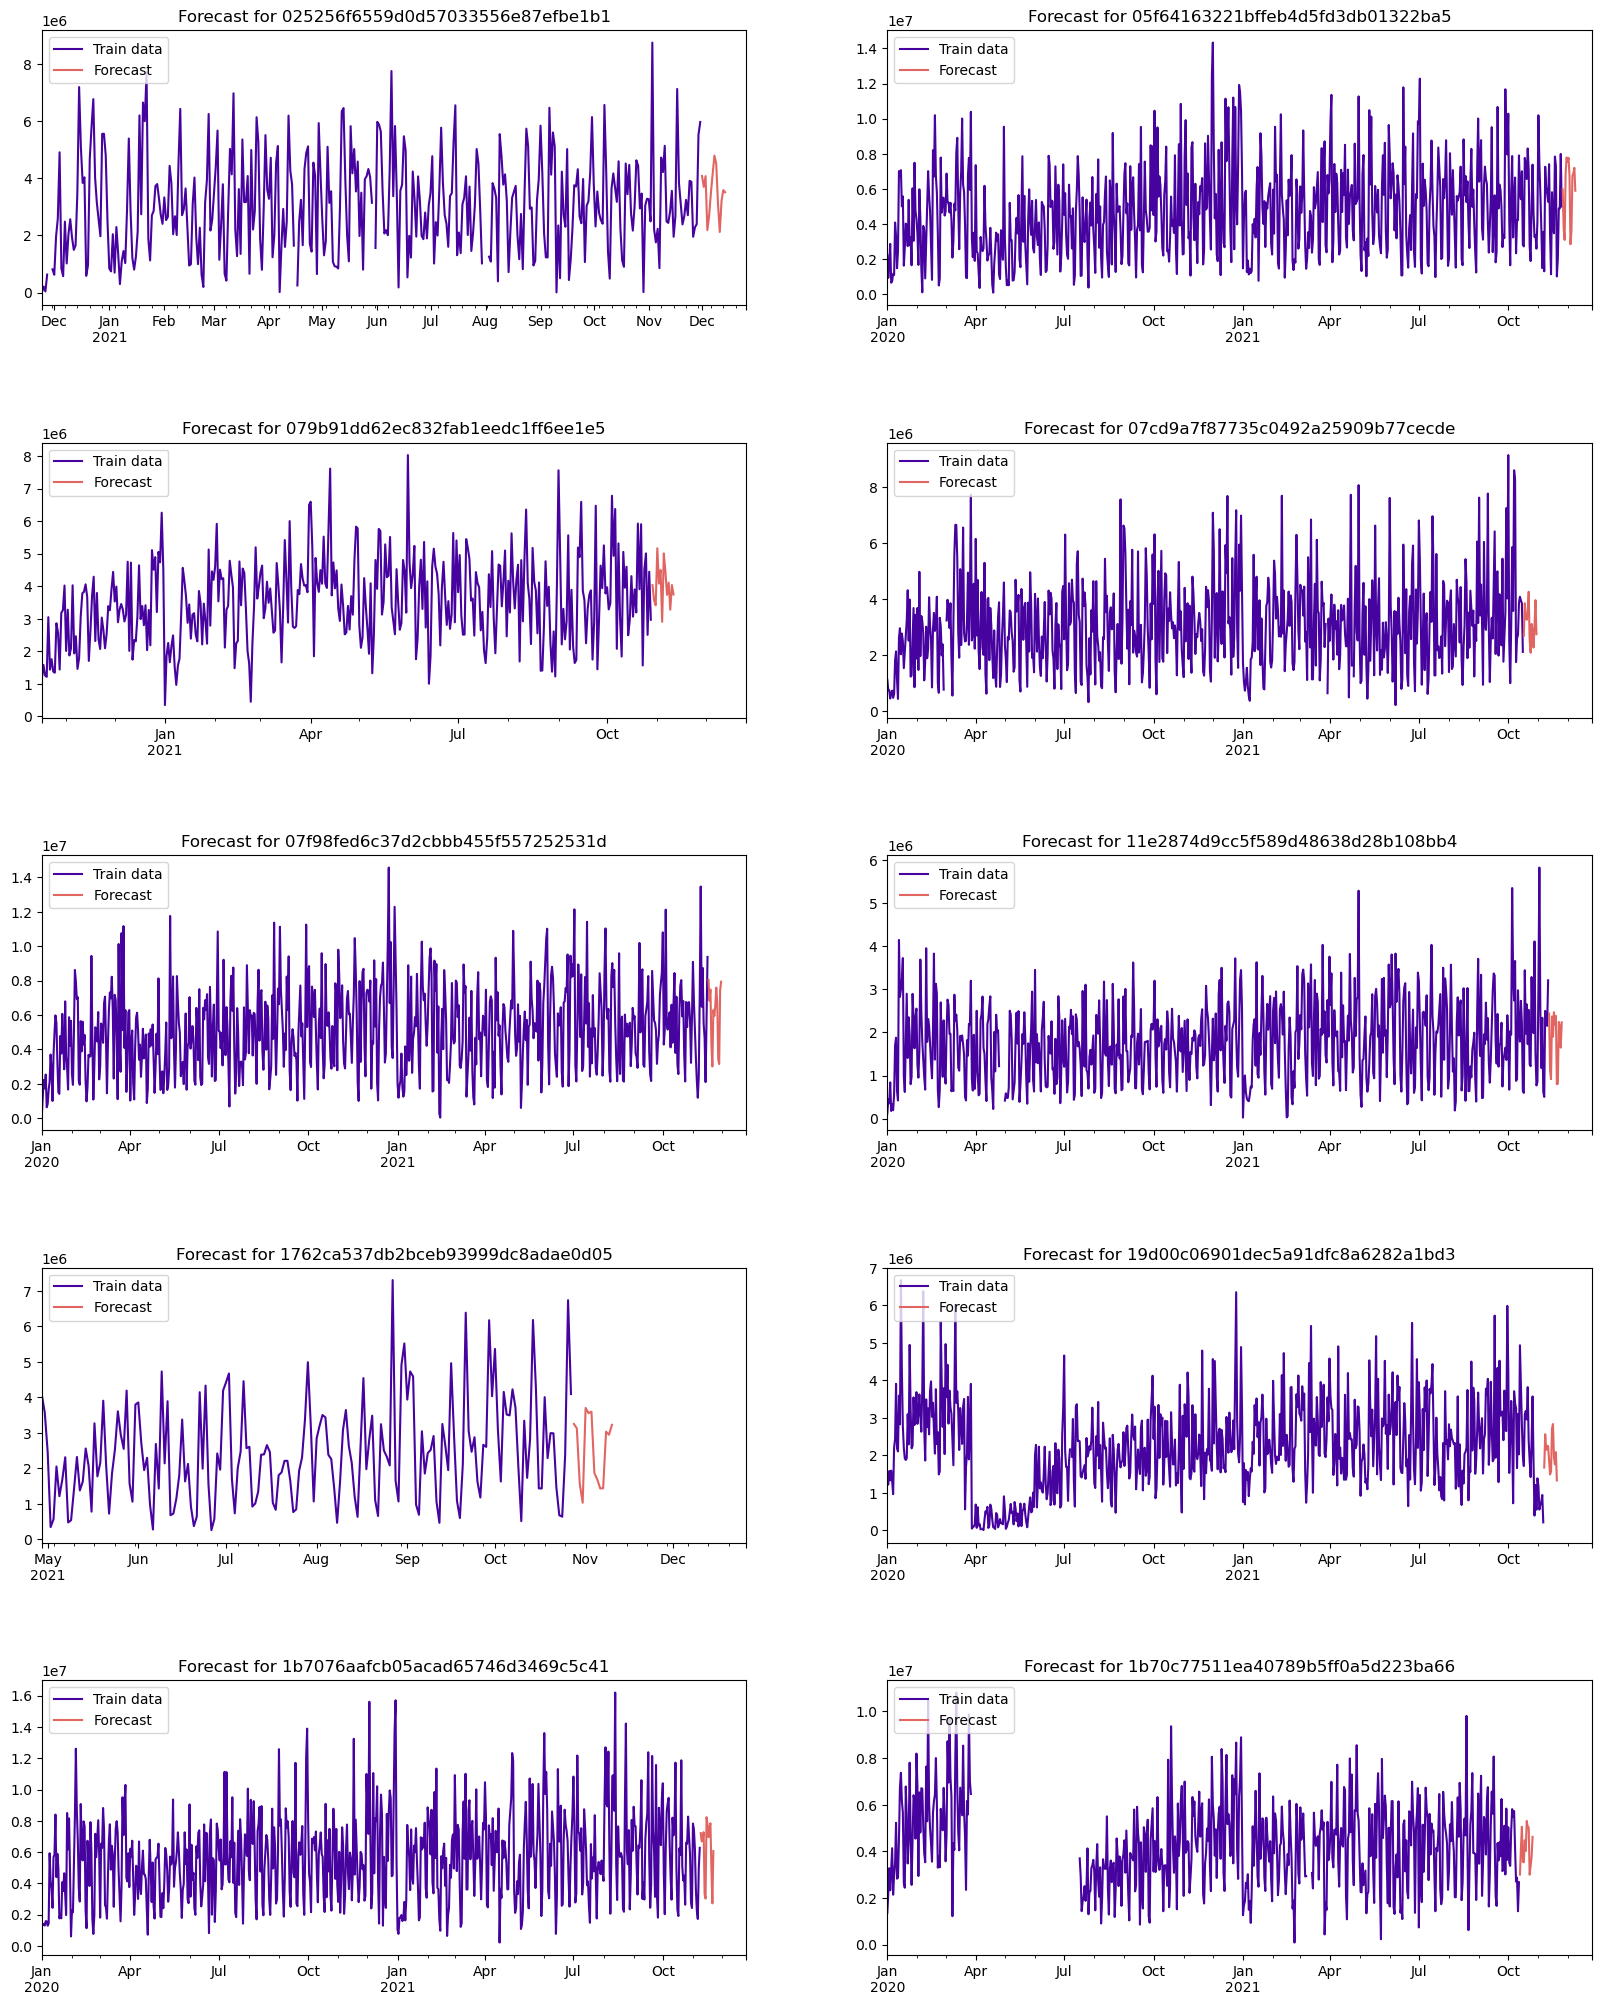

In [49]:
dict_plot_f(forecast_dict, n = 10)

In [142]:
# Функция записи саба
def get_sub(test_dict):
    keys = list(test_dict.keys())
    result_df = pd.DataFrame(columns=['atm_id', 'yhat'])
    
    for key in list(test_dict.keys()):
        ts_train_df = ts_train[:, key, 'target']
        test_df = test_dict[key][:, key, 'target']
        
        day_num = 1
        for index, value in test_df.items():
            atm_id = f"{key}_{day_num}"
            temp_df = pd.DataFrame({'atm_id': [atm_id],
#                                     'value_day': [index],
                                    'yhat': [value]})
            result_df = pd.concat([result_df, temp_df], ignore_index=True)
            day_num += 1
            
    return result_df

In [ ]:
# Первый сабмит по всем тестовым временным рядам
df_submition = get_sub(forecast_dict)
df_submition.to_csv('submition.csv', index=False)

### Далее стоит переобучить модели на данных, которые показали плохую метрику

In [24]:
mae_test_fail = pd.read_csv('/kaggle/input/dicts-alfa/mae_test_fail.csv')
test_df = preprocess_dataframe(df_test[df_test['atm_id'].isin(mae_test_fail['atm_id'])])
ts_train = TSDataset(test_df, freq="1D")


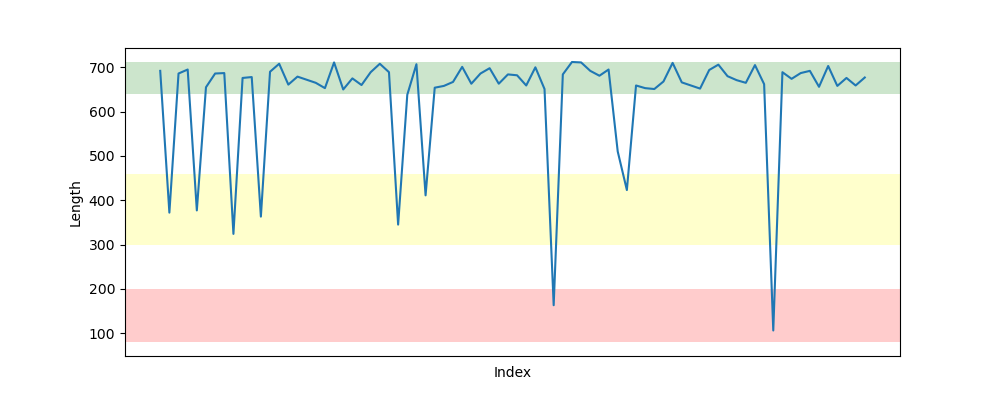

In [50]:
from IPython.display import HTML
from io import BytesIO
import base64

# Можно разделить их визуально на 3 категории: зеленые - длинные временные ряды, желтые - средние, красные - короткие
decribe_data = ts_train.describe()
y = decribe_data['length']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y)
ax.axhspan(80, 200, facecolor='red', alpha=0.2)
ax.axhspan(300, 460, facecolor='yellow', alpha=0.2)
ax.axhspan(640, max(y), facecolor='green', alpha=0.2)
plt.xticks([])
plt.xlabel('Index')
plt.ylabel('Length')

img = BytesIO()
plt.savefig(img, format='png')
img.seek(0)
plt.close()

html = '<div style="text-align: center;"><img src="data:image/png;base64,{}"/></div>'.format(base64.b64encode(img.read()).decode())
HTML(html)

In [51]:
# сгенерируем 3 типа датасетов
def generate_datasets(dataframes, freq="D"):
    datasets = {}
    for name, df in dataframes.items():
        df_preprocessed = preprocess_dataframe(df_test[df_test['atm_id'].isin(df.index)])
        ts_dataset = TSDataset(df_preprocessed, freq=freq)
        datasets[name] = ts_dataset
    return datasets

short_atm = decribe_data[(decribe_data['length'] >= 80) & (decribe_data['length'] < 200)]
middle_atm = decribe_data[(decribe_data['length'] >= 300) & (decribe_data['length'] < 460)]
long_atm = decribe_data[decribe_data['length'] >= 640]

dataframes = {'short_atm': short_atm, 'middle_atm': middle_atm, 'long_atm': long_atm}
datasets = generate_datasets(dataframes)

In [212]:
# меняя параметры для категорий датасетов получаем оптимальные (здесь методом подбора, что конечно можно улучшить)
def fixed_process_row(index, row):

    transforms_for_filtered = [
                 HolidayTransform(iso_code="RUS", out_column="regressor_RUS_holidays"),
                 TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=7),
#                  FourierTransform(period=365.25, order=4, out_column = 'ft'),
                 DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = True, week_number_in_month = True, week_number_in_year = True, 
                                    month_number_in_year = True, season_number = True, is_weekend = True),
                 LagTransform(in_column="target", lags=lag_for_transforms, out_column="target_lag")
#                  MRMRFeatureSelectionTransform(RelevanceTable, top_k = 20, features_to_use = 'all', return_features = True),
#                  TreeFeatureSelectionTransform(ExtraTreeRegressor, top_k = 30, features_to_use = 'all', return_features = False)
                 ]
    for lag in lag_for_transforms:
        lag_transforms = [
            MinMaxDifferenceTransform(in_column=f"target_lag_{lag}", out_column=f"target_minmax_diff_lag_{lag}", window=lag),
            MinTransform(in_column=f"target_lag_{lag}", out_column=f"target_Min_lag_{lag}", window=lag),
            MaxTransform(in_column=f"target_lag_{lag}", out_column=f"target_Max_lag_{lag}", window=lag) 
        ]
        transforms_for_filtered.extend(lag_transforms)
        
#     transforms_for_filtered.extend([TreeFeatureSelectionTransform(ExtraTreeRegressor, top_k = 30, features_to_use = 'all', return_features = False)])
        
    
    ts_temp = None
    temp_ts = None
    
    segment = index
    nan_day = row.end_timestamp.strftime('%Y-%m-%d')
    ts_temp = chain_tsdatasets(segment)

    temp_ts = ts_train[:(datetime.strptime(nan_day, '%Y-%m-%d')), segment, :]
    
    filtered_ts = TSDataset(temp_ts, freq=ts_train.freq)
    
    if isinstance(ts_temp, pd.DataFrame):
        
        filtered_ts.fit_transform([
                                   TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=9)
                                  ])
        
    else:
        exog = duplicate_data(ts_temp.df, segments=filtered_ts.segments)
        filtered_ts = TSDataset(temp_ts, freq=ts_train.freq, df_exog = exog, 
                                          known_future='all')
        filtered_ts.fit_transform([
                                   TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=9)
                                  ])
        del exog
    
    catboost_model_Per = CatBoostModelPerSegment(iterations = 150, learning_rate = 0.05)
    catboost_pipeline_Per = Pipeline(model=catboost_model_Per, transforms = transforms_for_filtered, horizon=HORIZON)
    catboost_pipeline_Per.fit(filtered_ts)
    if len(temp_ts) > (3*HORIZON*4):
        metrics, backtest, folds = catboost_pipeline_Per.backtest(filtered_ts, metrics=[MAE()], aggregate_metrics=True, 
                                                                  n_folds=6, n_jobs = 3,
                                                                 joblib_params = dict(verbose=0, backend="multiprocessing", mmap_mode="c"))
        forecast = catboost_pipeline_Per.forecast(filtered_ts, n_folds=6)
    else:
        metrics, backtest, folds = catboost_pipeline_Per.backtest(filtered_ts, metrics=[MAE()], aggregate_metrics=True, 
                                                                  n_folds=2, n_jobs = 2,
                                                                 joblib_params = dict(verbose=0, backend="multiprocessing", mmap_mode="c"))
        forecast = catboost_pipeline_Per.forecast(filtered_ts, n_folds=2)
    
    catboost_pipelines[segment] = catboost_pipeline_Per
    metrics_dict[segment] = metrics
    backtest_dict[segment] = backtest
    folds_dict[segment] = folds
    forecast_dict[segment] = forecast

    print(f"MAE(mean) of catboost for segment {segment}: ", metrics.mean()["MAE"])
    return catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict

In [ ]:
# модели для коротких рядов
catboost_pipelines = {}
backtest_dict = {}
forecast_dict = {}
metrics_dict = {}
folds_dict = {}
lag_for_transforms = list(range(14, 71, 7))
lag_transforms = []
ts_train = TSDataset(test_df, freq="1D")
    
for index, row in tqdm(short_atm.iterrows(), total = len(short_atm)):
    catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict = fixed_process_row(index, row)
    
df_submition_short = get_sub(forecast_dict)

In [ ]:
# модели для средних рядов
catboost_pipelines = {}
backtest_dict = {}
forecast_dict = {}
metrics_dict = {}
folds_dict = {}
lag_for_transforms = list(range(14, 71, 7))
lag_transforms = []
ts_train = TSDataset(test_df, freq="1D")

for index, row in tqdm(middle_atm.iterrows(), total = len(middle_atm)):
    catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict = fixed_process_row(index, row)
    
df_submition_middle = get_sub(forecast_dict)

In [ ]:
# модели для длинных рядов
catboost_pipelines = {}
backtest_dict = {}
forecast_dict = {}
metrics_dict = {}
folds_dict = {}
lag_for_transforms = list(range(70, 372, 7))
lag_transforms = []
ts_train = TSDataset(test_df, freq="D")

for index, row in tqdm(long_atm.iterrows(), total = len(long_atm)):
    catboost_pipelines, metrics_dict, backtest_dict, forecast_dict, folds_dict = fixed_process_row(index, row)
    
df_submition_long = get_sub(forecast_dict)

In [ ]:
# сохраним объединенный датасет
df_fixes = pd.concat([df_submition_long, df_submition_middle, df_submition_short], axis=0, ignore_index=True)
df_fixes.to_csv('df_fixes.csv', index=False)

In [24]:
# запишем обновленный саб
submition = pd.read_csv('/kaggle/input/dicts-alfa/submition.csv')
df_fixes = pd.read_csv('/kaggle/input/dicts-alfa/df_fixes.csv')

submition.set_index('atm_id', inplace=True)
df_fixes.set_index('atm_id', inplace=True)

submition.update(df_fixes)
submition.to_csv('submition.csv', index=True)

>В результате был существенно улучшен score от бейзлайна и требования к задаче выполнены, осталось ждать приглашения в магистратуру :з


<img src="https://raw.githubusercontent.com/akscent/kaggle-competitions/main/Alfa%20MIPT/img/sub.PNG">